###  XGBoost

In [ ]:
def xgboost_cv(df, k, size, markersize):
  train_x, test_x, train_y, test_y = data_split(df)
  train_x_scaled, test_x_scaled = data_scaling(train_x, test_x)

  mdl = XGBClassifier( n_estimators=20)


  cv_result = cross_validate(mdl, train_x_scaled, train_y, cv=5 ,scoring='accuracy',n_jobs=-1, return_train_score = True)


  mdl.fit(train_x_scaled, train_y)

  test_y_pred = mdl.predict(test_x_scaled)


  print("Training Accuracy:", mdl.score(train_x_scaled, train_y))
  print("Testing Accuracy:", mdl.score(test_x_scaled, test_y))


  pca_plot(test_x_scaled, test_y.to_numpy(), test_y_pred, size, markersize)
  return mdl

Training Accuracy: 0.9974747474747475
Testing Accuracy: 0.8831168831168831


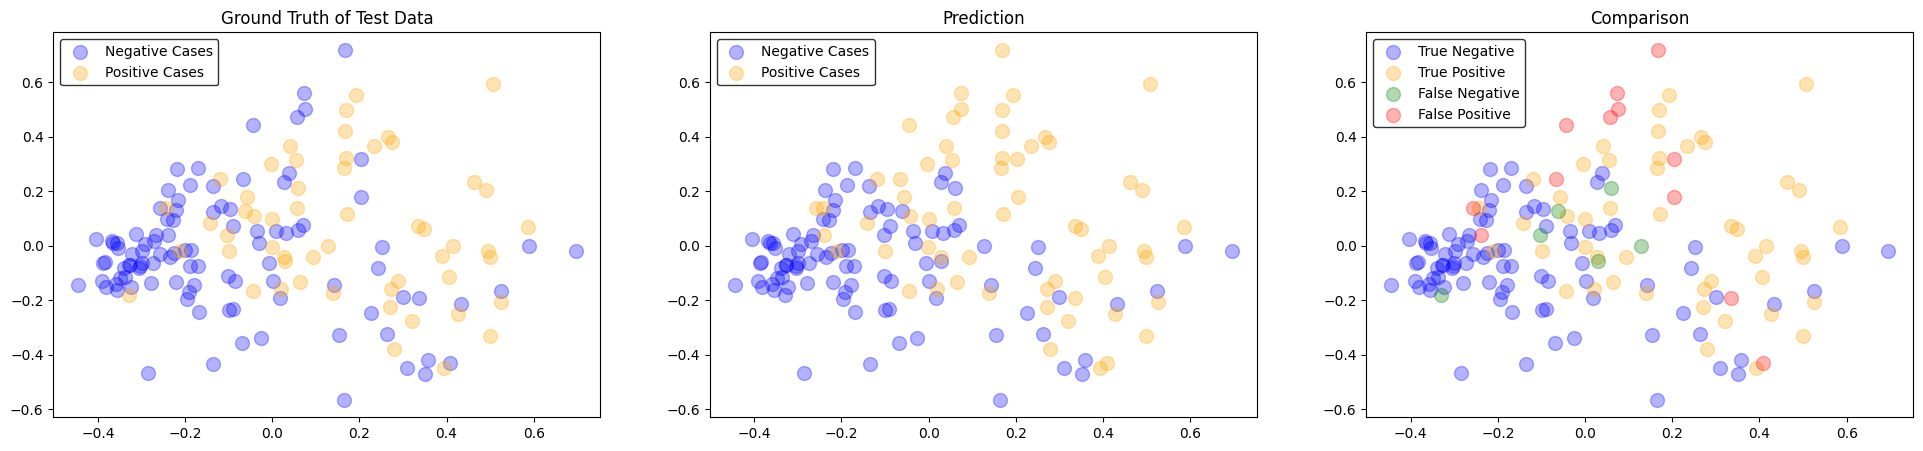

In [ ]:
xgboost=xgboost_cv(df,5, 100, 1)

In [ ]:
fn = X.columns
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=train_x_scaled,
    feature_names=X.columns,
    class_names=["Class 0", "Class 1"],
    mode='classification'
)
exp = explainer.explain_instance(
    data_row=test_x_scaled[0],
    predict_fn=xgboost.predict_proba
)

exp.show_in_notebook()

In [ ]:
train_x_scaled_df = pd.DataFrame(train_x_scaled, columns=X.columns)
test_x_scaled_df = pd.DataFrame(test_x_scaled, columns=X.columns)

background = shap.sample(train_x_scaled_df, 100)

explainer = shap.KernelExplainer(xgboost.predict_proba, background)

shap_values = explainer.shap_values(test_x_scaled_df)

  0%|          | 0/117 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

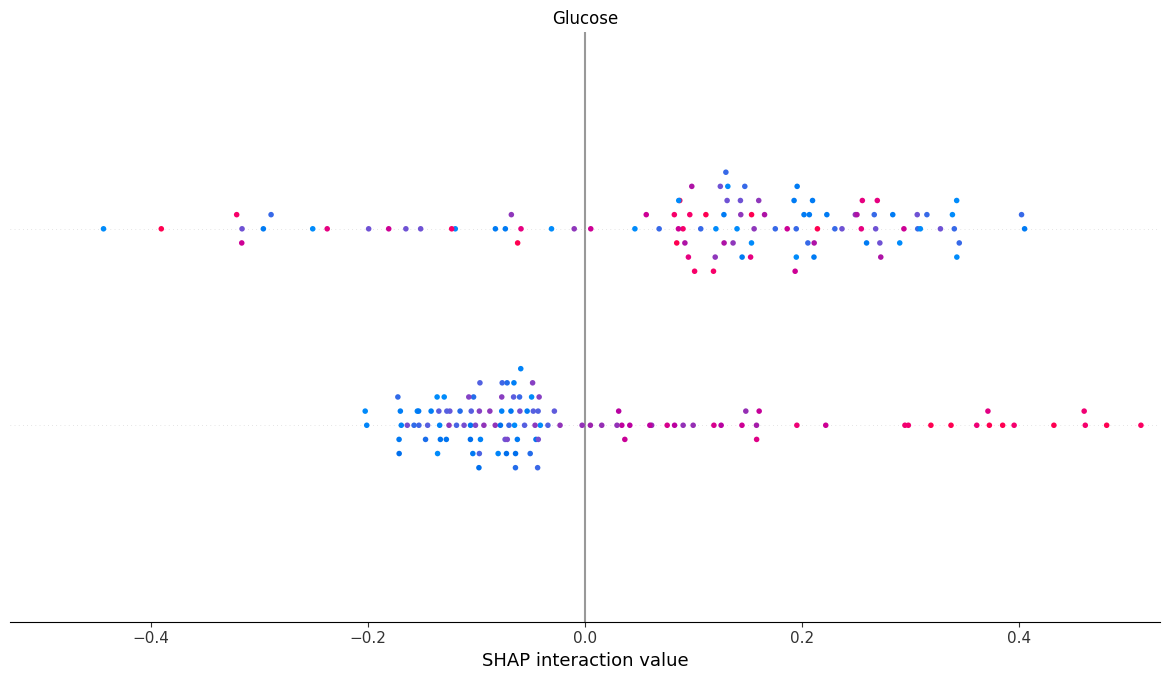

In [ ]:
shap.summary_plot(shap_values, test_x_scaled_df)

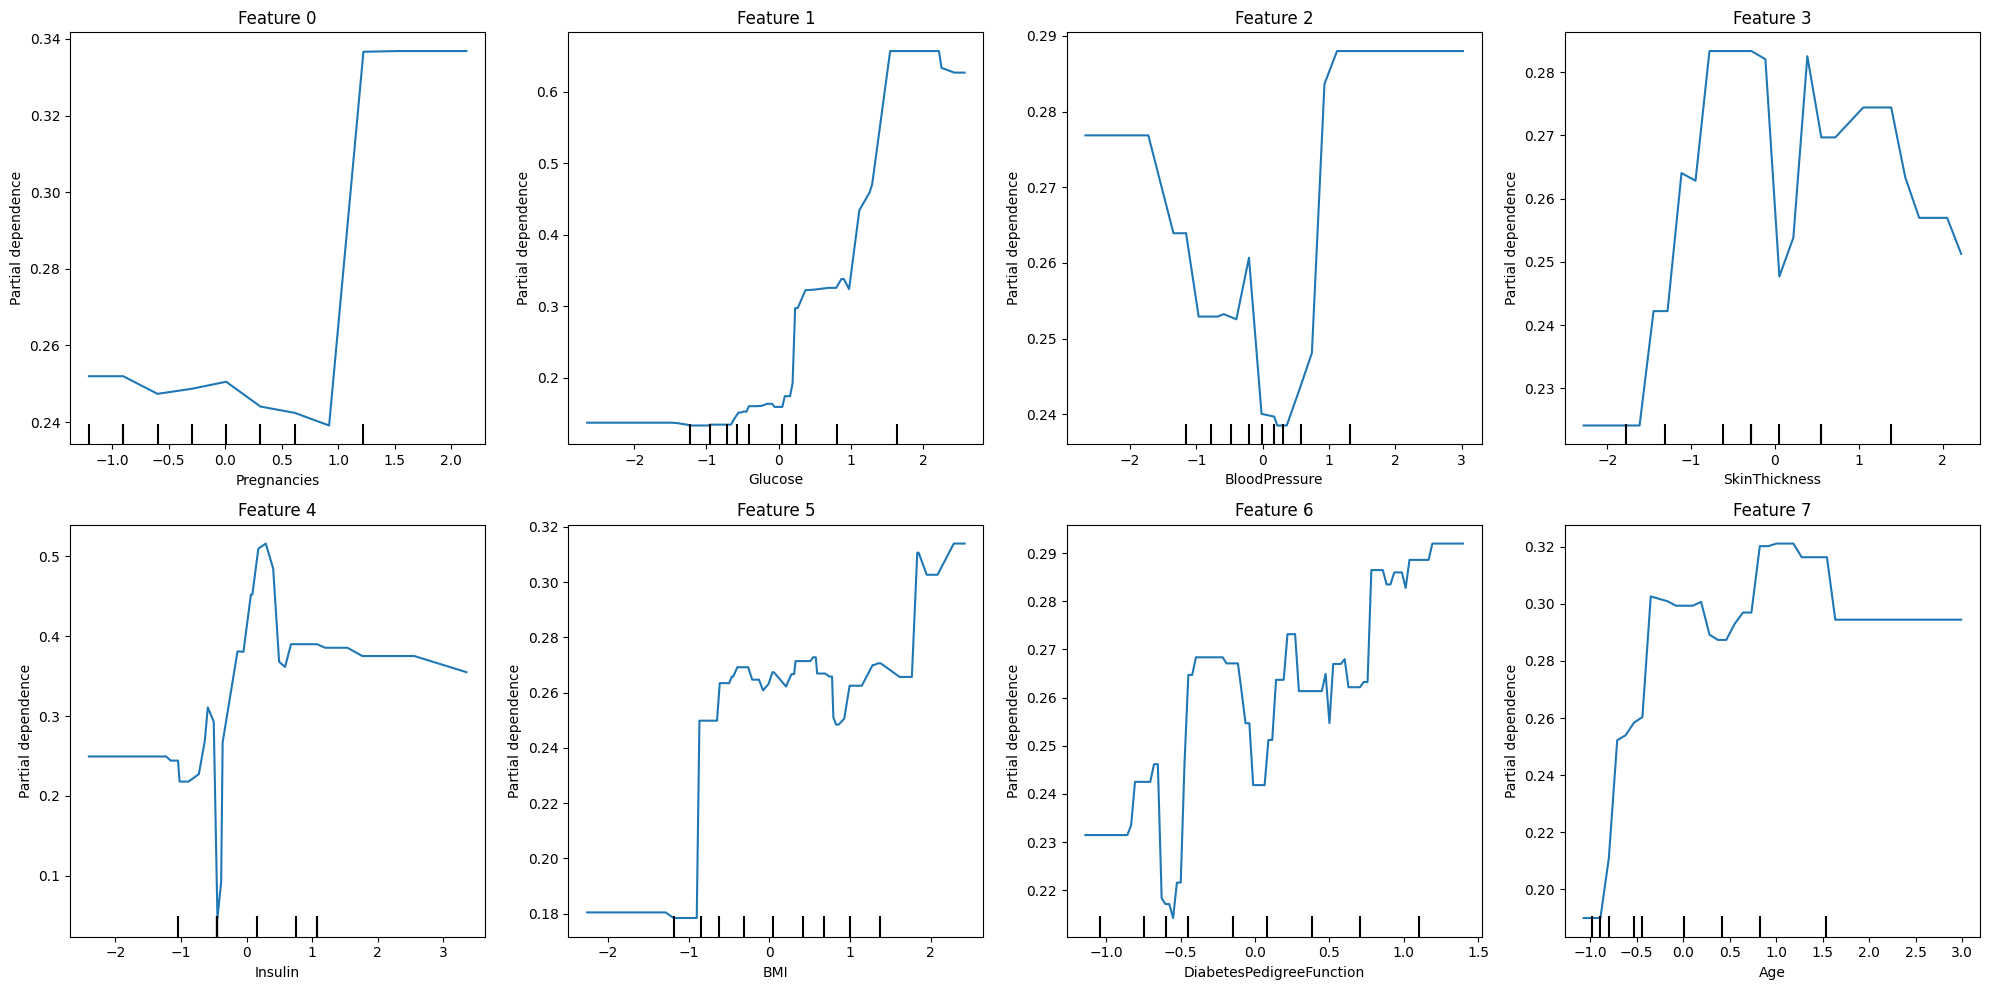

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()
for i in range(X.shape[1]):
  feature = [i]
  target_class = 0
  PartialDependenceDisplay.from_estimator(xgboost, test_x_scaled, features=feature,feature_names=X.columns, target=target_class, ax=axes[i])
  axes[i].set_title(f'Feature {i}')
plt.tight_layout()
plt.show()

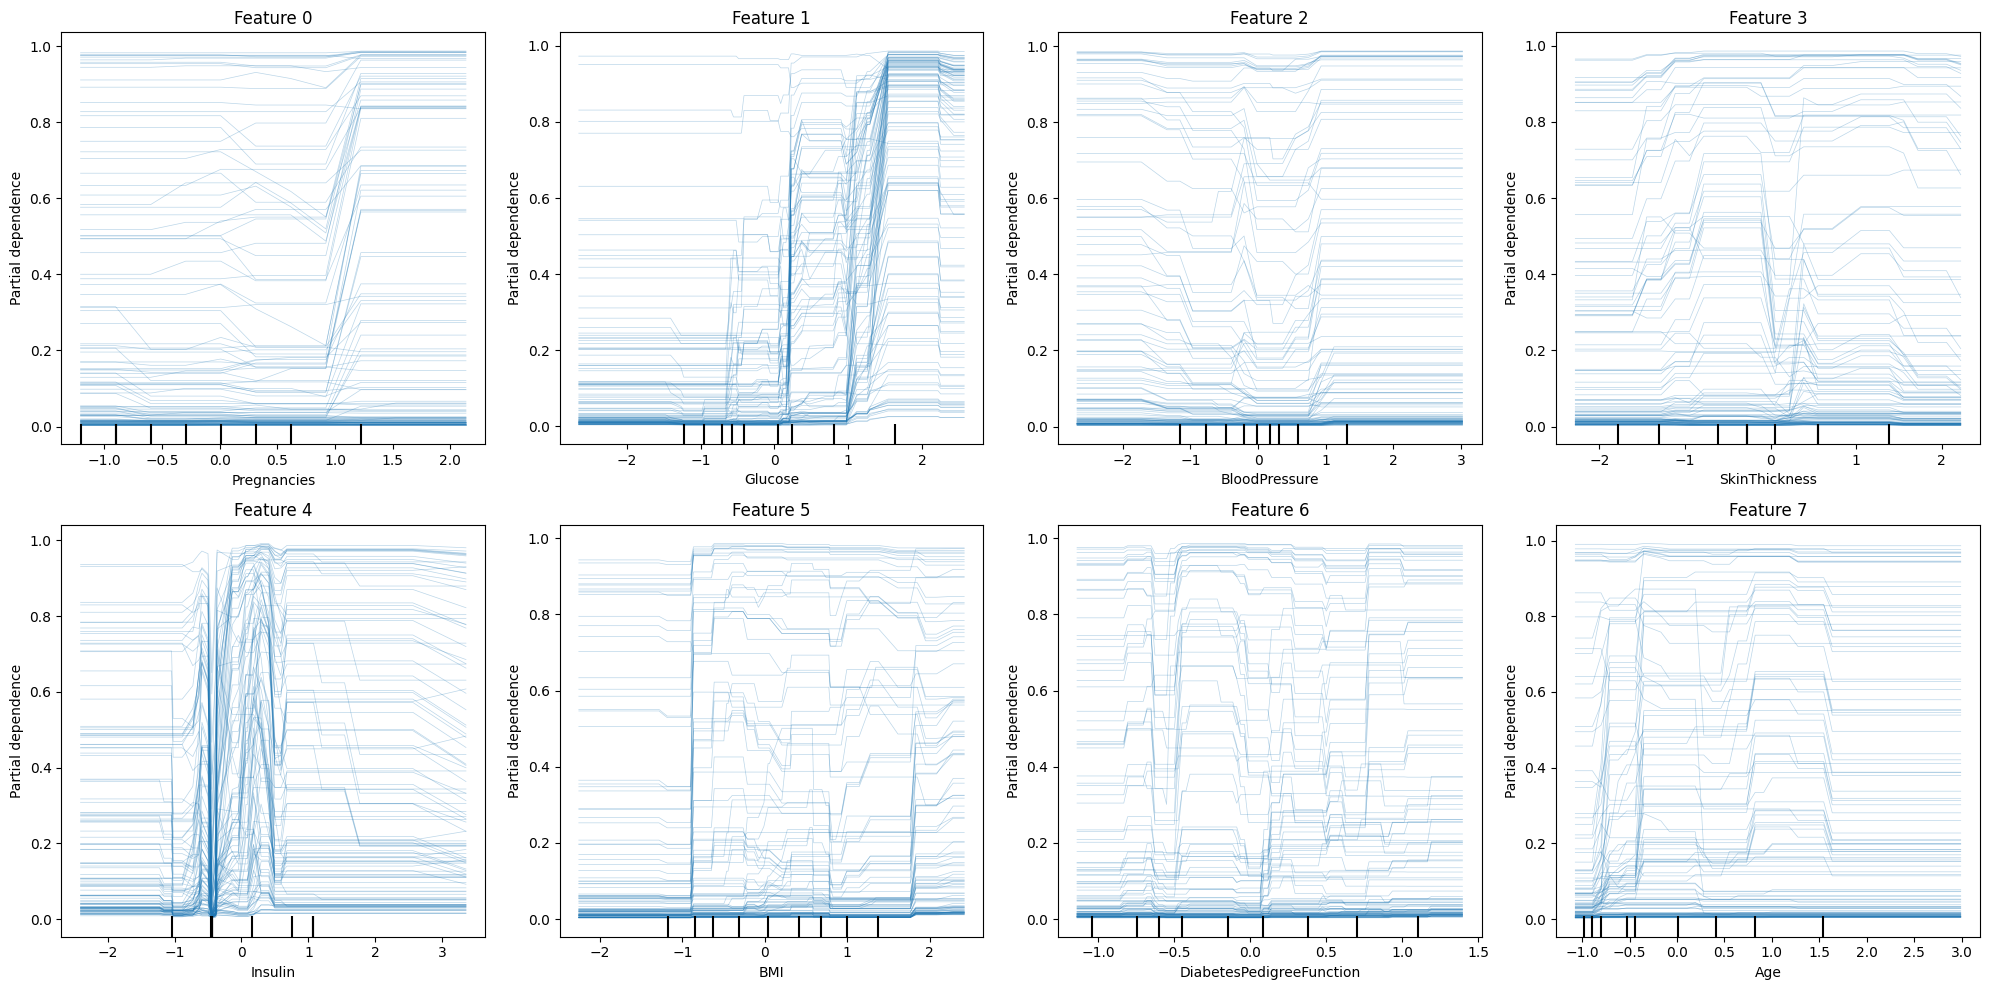

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()
for i in range(X.shape[1]):
  feature = [i]
  target_class = 0
  PartialDependenceDisplay.from_estimator(xgboost, test_x_scaled, features=feature,feature_names=X.columns, target=target_class, kind='individual', ax=axes[i])
  axes[i].set_title(f'Feature {i}')
plt.tight_layout()
plt.show()

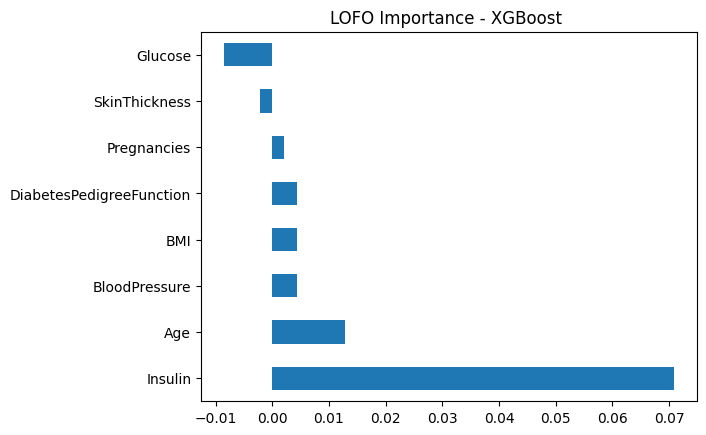

In [ ]:
baseline = cross_val_score(xgboost, train_x_scaled, train_y, cv=5).mean()

lofo_scores = {}
for col in X.columns:
    X_lofo = train_x_scaled_df.drop(columns=[col])
    score = cross_val_score(xgboost, X_lofo, train_y, cv=5).mean()
    lofo_scores[col] = baseline - score

lofo_df = pd.Series(lofo_scores).sort_values(ascending=False)
lofo_df.plot(kind='barh')
plt.title("LOFO Importance - XGBoost ")
plt.show()

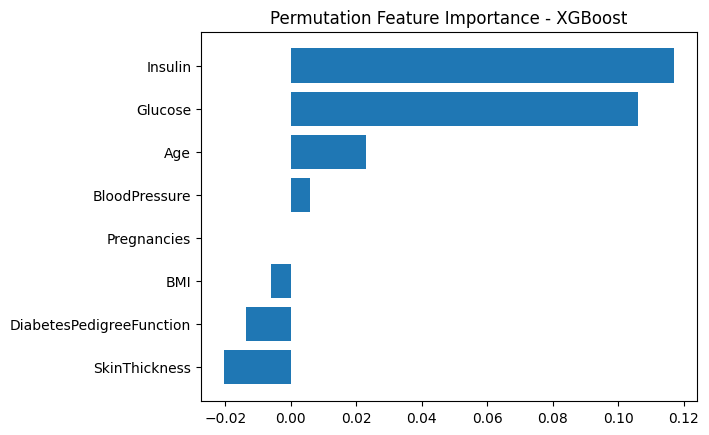

In [ ]:
result = permutation_importance(xgboost , test_x_scaled, test_y, n_repeats=10, random_state=42)
sorted_idx = result.importances_mean.argsort()

plt.barh(X.columns[sorted_idx], result.importances_mean[sorted_idx])
plt.title("Permutation Feature Importance - XGBoost")
plt.show()

In [ ]:
h_stat = FriedmanHStatisticMethod()
h_stat.fit(xgboost,train_x_scaled_df )

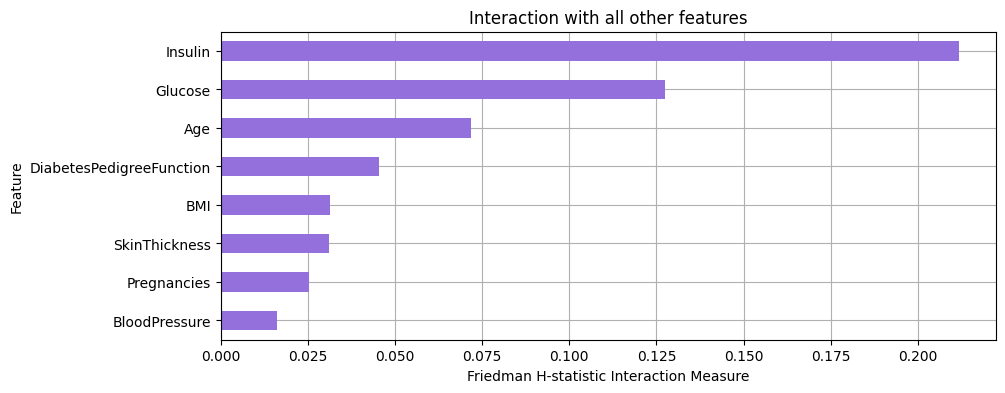

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))
h_stat.plot('bar_chart_ova',ax=ax)

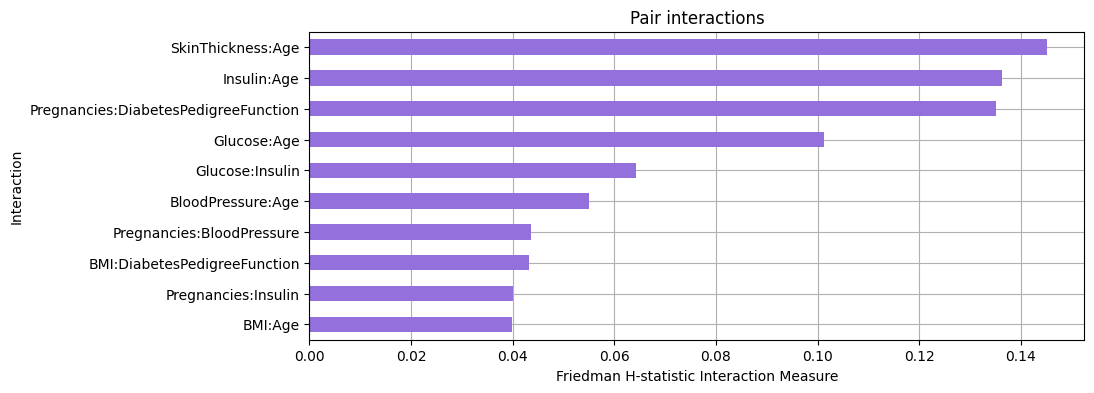

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))
h_stat.plot(vis_type='bar_chart',ax=ax)